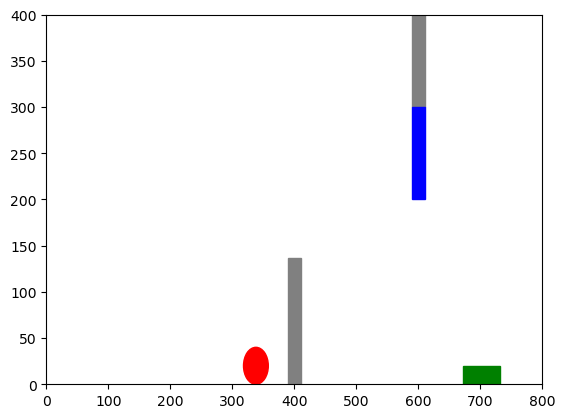

In [1]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Constants
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 400
BAR_WIDTH = 20
BAR_HEIGHT = 100
BALL_RADIUS = 20
BASKET_WIDTH = 60
BASKET_HEIGHT = 20
MOVEMENT_SPEED = 5
VELOCITY = 10

class BallSortCraneEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(BallSortCraneEnv, self).__init__()

        # Define action and observation space
        self.action_space = spaces.Discrete(5)
        self.observation_space = spaces.Box(low=0, high=max(SCREEN_WIDTH, SCREEN_HEIGHT), shape=(6,), dtype=np.float32)

        # Initialize game variables
        self.bar_x = SCREEN_WIDTH - (SCREEN_WIDTH // 4)
        self.bar_y = SCREEN_HEIGHT - (SCREEN_HEIGHT // 4)
        self.bar_height = BAR_HEIGHT
        self.extend_bar = False
        self.shrink_bar = False
        self.move_left = False
        self.move_right = False
        self.score = 0
        self.is_grabbing = False
        self.previous_distance_to_ball = float('inf')
        self.previous_distance_to_basket = float('inf')
        self.ball_x, self.ball_y, self.basket_x, self.basket_y, self.pillar_height = self.randomize_positions()
        self.figure, self.ax = plt.subplots()
        self.current_step = 0
        self.initial_bar_height = BAR_HEIGHT
    def randomize_positions(self):
        ball_x = random.randint(BALL_RADIUS, SCREEN_WIDTH // 2 - BALL_RADIUS)
        basket_x = random.randint(SCREEN_WIDTH // 2 + BASKET_WIDTH // 2, SCREEN_WIDTH - BASKET_WIDTH // 2)
        max_pillar_height = SCREEN_HEIGHT // 2
        pillar_height = random.randint(50, max_pillar_height)
        ball_y = BALL_RADIUS
        basket_y = BASKET_HEIGHT // 2
        return ball_x, ball_y, basket_x, basket_y, pillar_height
    
    def is_better_position_for_grabbing(self):
        # Check if the bar is getting closer to the ball
        current_distance_to_ball = np.linalg.norm([self.ball_x - self.bar_x, self.ball_y - (self.bar_y - self.bar_height)])
        is_getting_closer = current_distance_to_ball < self.previous_distance_to_ball
        
        # Check if extending the bar is beneficial for grabbing the ball
        is_correct_extension = self.extend_bar and self.bar_y - self.bar_height > self.ball_y

        return is_getting_closer or is_correct_extension

    def is_better_position_for_releasing(self):
        # Check if the bar (with the ball) is getting closer to the basket
        current_distance_to_basket = np.linalg.norm([self.basket_x - self.bar_x, self.basket_y - (self.bar_y - self.bar_height)])
        is_getting_closer = current_distance_to_basket < self.previous_distance_to_basket

        # Check if retracting the bar is beneficial for releasing the ball
        # This can be a simple condition based on the bar's position relative to the basket.
        is_correct_retraction = self.shrink_bar and self.ball_x == self.bar_x and self.bar_y - self.bar_height < self.basket_y

        return is_getting_closer or is_correct_retraction
    
    def step(self, action):

        if action == 0:  # Move Left
            self.move_left = True
            self.move_right = False
        elif action == 1:  # Move Right
            self.move_left = False
            self.move_right = True
        elif action == 2:  # Extend Bar
            self.extend_bar = True
            self.shrink_bar = False
        elif action == 3:  # Shrink Bar
            self.extend_bar = False
            self.shrink_bar = True
        elif action == 4:  # Grab/Release
            self.is_grabbing = not self.is_grabbing
        self.current_step += 1
        self.update_game_state()

        # Update previous distance to ball before updating game state
        self.previous_distance_to_ball = np.linalg.norm([self.ball_x - self.bar_x, self.ball_y - (self.bar_y - self.bar_height)])

        self.update_game_state()

        reward = self.calculate_reward()
        done = self.is_game_done()
        obs = np.array([self.ball_x, self.ball_y, self.bar_x, self.bar_y, self.basket_x, self.basket_y], dtype=np.float32)

        return obs, reward, done, {}


    def reset(self):
        self.current_step = 0
        self.bar_x, self.bar_y, self.bar_height = SCREEN_WIDTH - (SCREEN_WIDTH // 4), SCREEN_HEIGHT - (SCREEN_HEIGHT // 4), BAR_HEIGHT
        self.extend_bar, self.shrink_bar, self.move_left, self.move_right, self.is_grabbing = False, False, False, False, False
        self.score = 0
        self.previous_distance_to_ball = float('inf')
        self.previous_distance_to_basket = float('inf')
        self.ball_x, self.ball_y, self.basket_x, self.basket_y, self.pillar_height = self.randomize_positions()
        self.initial_bar_height = self.bar_height
        return np.array([self.ball_x, self.ball_y, self.bar_x, self.bar_y, self.basket_x, self.basket_y], dtype=np.float32)
    

    def render(self, mode='human'):
        
        self.ax.clear()
        self.ax.set_xlim(0, SCREEN_WIDTH)
        self.ax.set_ylim(0, SCREEN_HEIGHT)

        # Draw the pillar in the middle of the screen
        pillar_x = SCREEN_WIDTH // 2
        pillar = patches.Rectangle((pillar_x - 10, 0), 20, self.pillar_height, color='gray')
        self.ax.add_patch(pillar)

        # Draw the crane's arm and bar
        crane_base_x = self.bar_x
        crane_base_y = SCREEN_HEIGHT
        crane_arm_length = SCREEN_HEIGHT - self.bar_y + self.bar_height
        crane_arm = patches.Rectangle((crane_base_x - BAR_WIDTH/2, self.bar_y), BAR_WIDTH, crane_arm_length, color='gray')
        self.ax.add_patch(crane_arm)
        bar = patches.Rectangle((self.bar_x - BAR_WIDTH/2, self.bar_y - self.bar_height), BAR_WIDTH, self.bar_height, color='blue')
        self.ax.add_patch(bar)

        # Draw the ball
        ball = patches.Circle((self.ball_x, self.ball_y), BALL_RADIUS, color='red')
        self.ax.add_patch(ball)

        # Draw the basket
        basket = patches.Rectangle((self.basket_x - BASKET_WIDTH/2, self.basket_y - BASKET_HEIGHT/2), BASKET_WIDTH, BASKET_HEIGHT, color='green')
        self.ax.add_patch(basket)
        
        if mode == 'rgb_array':
            # Convert the plot to an RGB array
            self.figure.canvas.draw()
            width, height = self.figure.get_size_inches() * self.figure.get_dpi()
            image = np.frombuffer(self.figure.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(int(height), int(width), 3)
            return image
        elif mode == 'human':
            # [Existing code for human rendering]
            plt.draw()
            plt.pause(0.01)

    def close(self):
        plt.close(self.figure)

    def update_game_state(self):
        # Update bar position
        if self.move_left:
            self.bar_x = max(self.bar_x - MOVEMENT_SPEED, BAR_WIDTH / 2)
        if self.move_right:
            self.bar_x = min(self.bar_x + MOVEMENT_SPEED, SCREEN_WIDTH - BAR_WIDTH / 2)

        # Update bar height
        if self.extend_bar and self.bar_height < SCREEN_HEIGHT - self.bar_y:
            self.bar_height += 10
        if self.shrink_bar and self.bar_height > 10:
            self.bar_height -= 10

        # Handle ball grabbing logic
        if self.is_grabbing:
            # Check if the bar is above the ball
            if self.bar_x - BAR_WIDTH / 2 < self.ball_x < self.bar_x + BAR_WIDTH / 2 and \
               self.ball_y < self.bar_y - self.bar_height + BALL_RADIUS:
                self.ball_x = self.bar_x
                self.ball_y = self.bar_y - self.bar_height + BALL_RADIUS
        else:
            # Ball falls due to gravity
            if self.ball_y > BALL_RADIUS:
                self.ball_y -= VELOCITY
            else:
                self.ball_y = BALL_RADIUS  # Ensure ball doesn't go below the ground
                
    def is_ball_in_basket(self):
        # Check if the ball is within the horizontal boundaries of the basket
        ball_in_basket_horizontally = (self.ball_x + BALL_RADIUS > self.basket_x - BASKET_WIDTH / 2) and \
                                      (self.ball_x - BALL_RADIUS < self.basket_x + BASKET_WIDTH / 2)

        # Check if the ball is within the vertical boundaries of the basket
        ball_in_basket_vertically = (self.ball_y - BALL_RADIUS < self.basket_y + BASKET_HEIGHT / 2) and \
                                    (self.ball_y + BALL_RADIUS > self.basket_y - BASKET_HEIGHT / 2)

        # The ball is in the basket if it's within both horizontal and vertical boundaries
        return ball_in_basket_horizontally and ball_in_basket_vertically
    def is_directly_above_ball(self):
            # Define a threshold for being considered 'directly above'
            threshold = 10  # Adjust this value as needed

            # Check if the bar's horizontal position is close enough to the ball's position
            return abs(self.bar_x - self.ball_x) < threshold and self.ball_y < self.bar_y - self.bar_height
    def calculate_reward(self):
        # Calculate the current distance to the ball
        current_distance_to_ball = np.linalg.norm([self.ball_x - self.bar_x, self.ball_y - (self.bar_y - self.bar_height)])
        
        # Reward if the crane moves closer to the ball, else penalize
        if current_distance_to_ball < self.previous_distance_to_ball:
            reward = 1  # Positive reward for moving closer
        else:
            reward = -1  # Negative reward for moving away

        # Update the previous distance for the next step
        self.previous_distance_to_ball = current_distance_to_ball

        return reward

    def is_game_done(self):
        max_score = 50
        max_steps = 1000
        ball_in_basket = self.is_ball_in_basket()
        return self.score >= max_score or self.current_step >= max_steps or ball_in_basket


# Create and test your environment
env = BallSortCraneEnv()
env.reset()
env.render()

Episode: 1/10000, Total Reward: -4
Episode: 2/10000, Total Reward: 2
Episode: 3/10000, Total Reward: 6
Episode: 4/10000, Total Reward: 6
Episode: 5/10000, Total Reward: 10
Episode: 6/10000, Total Reward: -28
Episode: 7/10000, Total Reward: 10
Episode: 8/10000, Total Reward: -6
Episode: 9/10000, Total Reward: 2
Episode: 10/10000, Total Reward: 2
Episode: 11/10000, Total Reward: 10
Episode: 12/10000, Total Reward: -8
Episode: 13/10000, Total Reward: 16
Episode: 14/10000, Total Reward: 10
Episode: 15/10000, Total Reward: 10
Episode: 16/10000, Total Reward: -20
Episode: 17/10000, Total Reward: -14
Episode: 18/10000, Total Reward: 10
Episode: 19/10000, Total Reward: 4
Episode: 20/10000, Total Reward: 20
Episode: 21/10000, Total Reward: 18
Episode: 22/10000, Total Reward: 4
Episode: 23/10000, Total Reward: 12
Episode: 24/10000, Total Reward: 0
Episode: 25/10000, Total Reward: 2
Episode: 26/10000, Total Reward: 16
Episode: 27/10000, Total Reward: -6
Episode: 28/10000, Total Reward: 16
Episode

Episode: 226/10000, Total Reward: -2
Episode: 227/10000, Total Reward: -12
Episode: 228/10000, Total Reward: 32
Episode: 229/10000, Total Reward: 14
Episode: 230/10000, Total Reward: 16
Episode: 231/10000, Total Reward: 20
Episode: 232/10000, Total Reward: 38
Episode: 233/10000, Total Reward: 30
Episode: 234/10000, Total Reward: 46
Episode: 235/10000, Total Reward: 14
Episode: 236/10000, Total Reward: 12
Episode: 237/10000, Total Reward: 20
Episode: 238/10000, Total Reward: 24
Episode: 239/10000, Total Reward: 22
Episode: 240/10000, Total Reward: -8
Episode: 241/10000, Total Reward: -6
Episode: 242/10000, Total Reward: 38
Episode: 243/10000, Total Reward: 8
Episode: 244/10000, Total Reward: -4
Episode: 245/10000, Total Reward: 10
Episode: 246/10000, Total Reward: 12
Episode: 247/10000, Total Reward: 32
Episode: 248/10000, Total Reward: 18
Episode: 249/10000, Total Reward: 6
Episode: 250/10000, Total Reward: 36
Episode: 251/10000, Total Reward: 6
Episode: 252/10000, Total Reward: 10
Epi

Episode: 448/10000, Total Reward: 0
Episode: 449/10000, Total Reward: 8
Episode: 450/10000, Total Reward: -48
Episode: 451/10000, Total Reward: -46
Episode: 452/10000, Total Reward: 0
Episode: 453/10000, Total Reward: 16
Episode: 454/10000, Total Reward: 0
Episode: 455/10000, Total Reward: 12
Episode: 456/10000, Total Reward: 8
Episode: 457/10000, Total Reward: 18
Episode: 458/10000, Total Reward: 40
Episode: 459/10000, Total Reward: -32
Episode: 460/10000, Total Reward: -50
Episode: 461/10000, Total Reward: 0
Episode: 462/10000, Total Reward: 12
Episode: 463/10000, Total Reward: 44
Episode: 464/10000, Total Reward: -2
Episode: 465/10000, Total Reward: 0
Episode: 466/10000, Total Reward: 2
Episode: 467/10000, Total Reward: 0
Episode: 468/10000, Total Reward: 50
Episode: 469/10000, Total Reward: -6
Episode: 470/10000, Total Reward: 48
Episode: 471/10000, Total Reward: -4
Episode: 472/10000, Total Reward: 20
Episode: 473/10000, Total Reward: 10
Episode: 474/10000, Total Reward: 36
Episod

Episode: 667/10000, Total Reward: -50
Episode: 668/10000, Total Reward: -50
Episode: 669/10000, Total Reward: -50
Episode: 670/10000, Total Reward: -50
Episode: 671/10000, Total Reward: -50
Episode: 672/10000, Total Reward: -50
Episode: 673/10000, Total Reward: -50
Episode: 674/10000, Total Reward: -50
Episode: 675/10000, Total Reward: -50
Episode: 676/10000, Total Reward: -50
Episode: 677/10000, Total Reward: -14
Episode: 678/10000, Total Reward: -48
Episode: 679/10000, Total Reward: -50
Episode: 680/10000, Total Reward: 6
Episode: 681/10000, Total Reward: -50
Episode: 682/10000, Total Reward: -50
Episode: 683/10000, Total Reward: 2
Episode: 684/10000, Total Reward: 28
Episode: 685/10000, Total Reward: 8
Episode: 686/10000, Total Reward: -4
Episode: 687/10000, Total Reward: 42
Episode: 688/10000, Total Reward: 48
Episode: 689/10000, Total Reward: 50
Episode: 690/10000, Total Reward: 36
Episode: 691/10000, Total Reward: 24
Episode: 692/10000, Total Reward: -22
Episode: 693/10000, Total

Episode: 887/10000, Total Reward: 50
Episode: 888/10000, Total Reward: 24
Episode: 889/10000, Total Reward: 6
Episode: 890/10000, Total Reward: 50
Episode: 891/10000, Total Reward: 16
Episode: 892/10000, Total Reward: 14
Episode: 893/10000, Total Reward: 26
Episode: 894/10000, Total Reward: 40
Episode: 895/10000, Total Reward: 42
Episode: 896/10000, Total Reward: -6
Episode: 897/10000, Total Reward: 14
Episode: 898/10000, Total Reward: 4
Episode: 899/10000, Total Reward: 18
Episode: 900/10000, Total Reward: 48
Saved model at episode 900
Episode: 901/10000, Total Reward: 48
Episode: 902/10000, Total Reward: 50
Episode: 903/10000, Total Reward: 42
Episode: 904/10000, Total Reward: 32
Episode: 905/10000, Total Reward: 20
Episode: 906/10000, Total Reward: 14
Episode: 907/10000, Total Reward: 22
Episode: 908/10000, Total Reward: 34
Episode: 909/10000, Total Reward: 50
Episode: 910/10000, Total Reward: 42
Episode: 911/10000, Total Reward: 6
Episode: 912/10000, Total Reward: 46
Episode: 913/1

Episode: 1105/10000, Total Reward: -4
Episode: 1106/10000, Total Reward: 28
Episode: 1107/10000, Total Reward: 32
Episode: 1108/10000, Total Reward: 24
Episode: 1109/10000, Total Reward: 44
Episode: 1110/10000, Total Reward: -2
Episode: 1111/10000, Total Reward: 22
Episode: 1112/10000, Total Reward: -6
Episode: 1113/10000, Total Reward: 36
Episode: 1114/10000, Total Reward: 26
Episode: 1115/10000, Total Reward: 50
Episode: 1116/10000, Total Reward: 50
Episode: 1117/10000, Total Reward: -4
Episode: 1118/10000, Total Reward: 20
Episode: 1119/10000, Total Reward: 24
Episode: 1120/10000, Total Reward: 16
Episode: 1121/10000, Total Reward: 30
Episode: 1122/10000, Total Reward: 46
Episode: 1123/10000, Total Reward: 48
Episode: 1124/10000, Total Reward: 22
Episode: 1125/10000, Total Reward: 14
Episode: 1126/10000, Total Reward: 46
Episode: 1127/10000, Total Reward: 50
Episode: 1128/10000, Total Reward: 18
Episode: 1129/10000, Total Reward: 46
Episode: 1130/10000, Total Reward: 50
Episode: 113

Episode: 1320/10000, Total Reward: 0
Episode: 1321/10000, Total Reward: 44
Episode: 1322/10000, Total Reward: 50
Episode: 1323/10000, Total Reward: 50
Episode: 1324/10000, Total Reward: -2
Episode: 1325/10000, Total Reward: 24
Episode: 1326/10000, Total Reward: 28
Episode: 1327/10000, Total Reward: 16
Episode: 1328/10000, Total Reward: -4
Episode: 1329/10000, Total Reward: 46
Episode: 1330/10000, Total Reward: 4
Episode: 1331/10000, Total Reward: 50
Episode: 1332/10000, Total Reward: -2
Episode: 1333/10000, Total Reward: 4
Episode: 1334/10000, Total Reward: 28
Episode: 1335/10000, Total Reward: 42
Episode: 1336/10000, Total Reward: 42
Episode: 1337/10000, Total Reward: 50
Episode: 1338/10000, Total Reward: 50
Episode: 1339/10000, Total Reward: 30
Episode: 1340/10000, Total Reward: 22
Episode: 1341/10000, Total Reward: 50
Episode: 1342/10000, Total Reward: 50
Episode: 1343/10000, Total Reward: 0
Episode: 1344/10000, Total Reward: 8
Episode: 1345/10000, Total Reward: -8
Episode: 1346/100

Episode: 1537/10000, Total Reward: 50
Episode: 1538/10000, Total Reward: 32
Episode: 1539/10000, Total Reward: 44
Episode: 1540/10000, Total Reward: 38
Episode: 1541/10000, Total Reward: 16
Episode: 1542/10000, Total Reward: 30
Episode: 1543/10000, Total Reward: 14
Episode: 1544/10000, Total Reward: 44
Episode: 1545/10000, Total Reward: 12
Episode: 1546/10000, Total Reward: 24
Episode: 1547/10000, Total Reward: 20
Episode: 1548/10000, Total Reward: 28
Episode: 1549/10000, Total Reward: 14
Episode: 1550/10000, Total Reward: 40
Episode: 1551/10000, Total Reward: 42
Episode: 1552/10000, Total Reward: 46
Episode: 1553/10000, Total Reward: 24
Episode: 1554/10000, Total Reward: 32
Episode: 1555/10000, Total Reward: 28
Episode: 1556/10000, Total Reward: 48
Episode: 1557/10000, Total Reward: 40
Episode: 1558/10000, Total Reward: 16
Episode: 1559/10000, Total Reward: -2
Episode: 1560/10000, Total Reward: 50
Episode: 1561/10000, Total Reward: 30
Episode: 1562/10000, Total Reward: 50
Episode: 156

KeyboardInterrupt: 

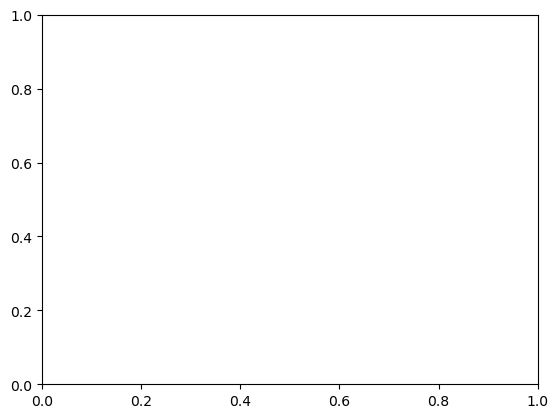

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import gym
import matplotlib.pyplot as plt

# Define the Q-network using PyTorch
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check for GPU availability
        self.q_network = QNetwork(state_size, action_size).to(self.device)  # Move model to GPU
        self.target_network = QNetwork(state_size, action_size).to(self.device)  # Move model to GPU
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).to(self.device)
        q_values = self.q_network(state)
        return q_values.argmax().item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.FloatTensor(np.array(states)).to(self.device)  # Convert to single numpy ndarray
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)  # Convert to single numpy ndarray
        dones = torch.FloatTensor(dones).to(self.device)

        q_values = self.q_network(states)
        q_values_next = self.target_network(next_states).max(1)[0].unsqueeze(1)
        q_targets = rewards + (1 - dones) * self.gamma * q_values_next

        loss = self.criterion(q_values.gather(1, actions.unsqueeze(1)), q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Assuming your environment is named 'BallSortCraneEnv'
env = BallSortCraneEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
agent.q_network.load_state_dict(torch.load('dqn_model.pth'))  # Load the trained model

EPISODES = 10000  # or your preferred number of episodes
MAX_STEPS = 50  # or your preferred steps per episode
batch_size = 64  # or your preferred batch size
total_rewards = []
average_losses = []

# Load the saved Q-network state_dict
#agent.q_network.load_state_dict(torch.load('.\dqn_model.pth'))

for e in range(EPISODES):
    state = env.reset()
    total_reward = 0

    for time in range(MAX_STEPS):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        # Perform the replay
        agent.replay(batch_size)

        # Update target network periodically
        if time % 20 == 0:
            agent.update_target_network()

    total_rewards.append(total_reward)
    agent.decay_epsilon()  # Decay exploration rate over time
    print(f"Episode: {e+1}/{EPISODES}, Total Reward: {total_reward}")
    
    # Check if it's time to save the model
    if (e + 1) % 100 == 0:
        # Save the Q-network state_dict to a file
        torch.save(agent.q_network.state_dict(), f'dqn_model.pth')
        print(f"Saved model at episode {e + 1}")
        
# Plot the rewards
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Performance')
plt.show()


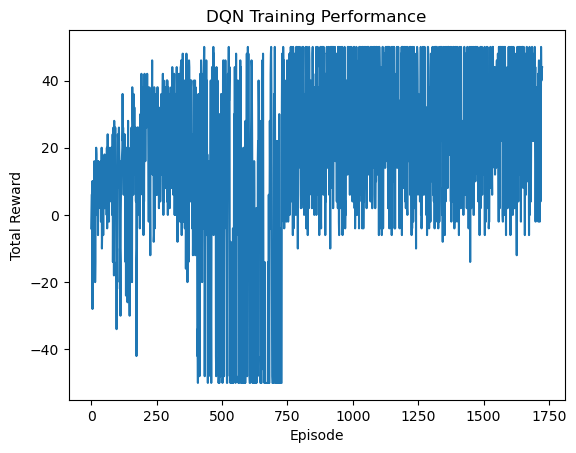

In [7]:
# Plot the rewards
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Performance')
plt.show()